# BN Generation 

This notebook sweeps over DAG/BN generation parameters outlined in `notebooks/graph_generation/ideas.md` and materializes multiple discrete BN variants per DAG.

It varies:
- n (number of variables)
- target treewidth
- variable arity (fixed or range)
- CPT skewness (Dirichlet alpha)

Outputs:
- CSV with per-variant metadata
- Picke with all generate networks

In [1]:
import sys
from pathlib import Path
import pandas as pd

# Ensure src is importable
repo_root = Path(".").resolve().parents[1]
sys.path.append(str(repo_root / 'src'))
from experiments.bn_query_sweep import generate_bayesian_networks_and_metadata

- For each DAG, we have 2 networks, because we have 2 values for alpha. That's why variants is 1, I don't think we need multiple parameter combinations for the same network.

In [2]:
# Parameter grids 
ns = [4, 6, 8, 10, 12, 15, 25, 50]
treewidths = {
    4:  [2, 3],
    6:  [2, 4],
    8:  [2, 4, 6],
    10: [2, 4, 6],
    12: [2, 4, 6],
    15: [2, 4, 6],
    25: [3],
    50: [3],
}
arity_specs = [
    #{"type": "fixed", "fixed": 2},
    {"type": "range", "min": 2, "max": 3},
]
dirichlet_alphas = [1.0, 0.5]
determinism_fracs = [0.0]  
#naming_strategies = ['simple', 'confusing', 'semantic']  # Add naming strategy variation
naming_strategies = ['confusing']  # Add naming strategy variation
variants_per_combo = 1
base_seed = 42

In [3]:
rows = []
all_bayesian_networks = []  # Store all BNs and their metadata
all_bayesian_networks, rows, preview_samples = generate_bayesian_networks_and_metadata(
    ns=ns,
    treewidths=treewidths,
    arity_specs=arity_specs,
    dirichlet_alphas=dirichlet_alphas,
    determinism_fracs=determinism_fracs,
    naming_strategies=naming_strategies,
    variants_per_combo=variants_per_combo,
    base_seed=base_seed,
    max_preview_samples=3
)

print(f"Generated {len(all_bayesian_networks)} Bayesian networks")
print(f"Created {len(rows)} metadata rows")


Generated 36 Bayesian networks
Created 36 metadata rows


In [4]:
# Filter out BNs where the number of edges is less than twice the number of nodes
from bn_utils import num_edges

filtered_bn_list = []
filtered_rows = []

# Map original BN indices to their indices in the filtered list
original_bn_idx_to_filtered_idx = {}

for orig_idx, (bn_dict, row) in enumerate(zip(all_bayesian_networks, rows)):
    bn = bn_dict["bn"]
    n_nodes = len(bn.nodes())
    n_edges = num_edges(bn)
    if n_edges >= 2 * n_nodes:
        filtered_bn_list.append(bn_dict)
        filtered_rows.append(row)
        original_bn_idx_to_filtered_idx[orig_idx] = len(filtered_bn_list) - 1

# Overwrite the master lists with the filtered ones
#all_bayesian_networks = filtered_bn_list
#rows = filtered_rows
print(f"After filtering, {len(all_bayesian_networks)} Bayesian networks remain.")

After filtering, 36 Bayesian networks remain.


In [5]:
df = pd.DataFrame(rows)
# Drop columns 'determinism' and 'target_tw'
df = df.drop(columns=['determinism', 'target_tw', 'arity', 'n'])

# Add columns: num_nodes / num_edges and average markov blanket size

from bn_utils import compute_average_markov_blanket_size
# Add new columns
num_nodes_list = []
num_edges_list = []
avg_mb_size_list = []

for i, row in df.iterrows():
    # get the BN corresponding to this row (by index)
    bn_idx = row.get("bn_index", i)
    # fallback: try both filtered_bn_list and all_bayesian_networks
    if "bn_index" in row and row["bn_index"] in range(len(all_bayesian_networks)):
        bn = all_bayesian_networks[int(row["bn_index"])]["bn"]
    elif i < len(all_bayesian_networks):
        bn = all_bayesian_networks[i]["bn"]
    else:
        # fallback to the filtered list if needed
        bn = filtered_bn_list[i]["bn"]
    num_nodes = len(bn.nodes())
    num_edges_ = num_edges(bn)
    avg_mb = compute_average_markov_blanket_size(bn)
    num_nodes_list.append(num_nodes)
    num_edges_list.append(num_edges_)
    avg_mb_size_list.append(avg_mb)

df['num_nodes/num_edges'] = [n/e for n, e in zip(num_nodes_list, num_edges_list)]
df['avg_markov_blanket_size'] = avg_mb_size_list


display(df)
print(f"Total variants: {len(df)}")

,achieved_tw,naming,alpha,seed,variant_index,num_edges,num_nodes,num_nodes/num_edges,avg_markov_blanket_size
0,2,confusing,1.0,42,0,4,4,1.000000,2.000000
1,2,confusing,0.5,43,0,4,4,1.000000,2.000000
2,3,confusing,1.0,44,0,6,4,0.666667,3.000000
3,3,confusing,0.5,45,0,6,4,0.666667,3.000000
4,2,confusing,1.0,46,0,6,6,1.000000,2.666667
5,2,confusing,0.5,47,0,6,6,1.000000,2.666667
6,4,confusing,1.0,48,0,13,6,0.461538,5.000000
7,4,confusing,0.5,49,0,13,6,0.461538,5.000000
8,2,confusing,1.0,50,0,8,8,1.000000,3.250000
9,2,confusing,0.5,51,0,8,8,1.000000,3.250000


Total variants: 36


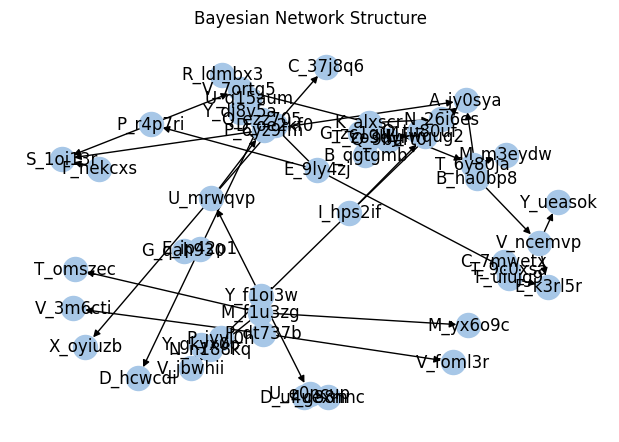

In [6]:
bn = all_bayesian_networks[35]["bn"]

# Draw BN
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(bn.nodes())
G.add_edges_from(bn.edges())
pos = nx.spring_layout(G, seed=0)
plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color="#A7C7E7", arrows=True)
plt.title("Bayesian Network Structure")
plt.show()

In [7]:
import pickle

# Save all_bayesian_networks to disk
with open("all_bayesian_networks.pkl", "wb") as f:
    pickle.dump(all_bayesian_networks, f)

# Save df to CSV
df.to_csv("bayesian_networks_metadata.csv", index=False)
